# Análise dos Resultados da Otimização dos Parâmetros

# Índice:
   * [Descrição](#description)
      * [Objetivos](#goals)
   * [Imports](#imports)
   * [Recuperação dos Dados do MLFlow](#recover)
       *[Modelos](#recoverModels)
       *[Resultados](#recoverResults)
   * [Análise](#analysis)
      * [Plot de Coordenadas Paralelas](#parallel)
      * [Plos de Desemepenho](#plotScore)
      * [Estrutura das Árvores](#treeStructure)
      * [Importância das Características](#featureImportance)
      * [p-valor](#pvalue)

In [18]:
%pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 2.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 7.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 1.3 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Descrição<a class="anchor" id="description"></a>

Esse notebook recupera os dados da busca de híper-parâmetros e analisa os resultados. São analisados o desempenho dos modelos nos testes, as estruturas de árvores com diferentes parâmetros e a importância das características utilizadas.

### Objetivos<a class="anchor" id="goals"></a>
   * Entender como os parâmetros de uma árvore de decisão influenciam sua estrutura e no seu desempenho no problema.
   * Apontar parâmetros ideais para o modelo baseado árvore de decisão para o problema.


## Imports

In [1]:
from time import time
import tempfile
import os

import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import mlflow
from mlflow.tracking import MlflowClient
from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID
from mlflow.entities import ViewType

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl


## Conexão com o MLflow

Para exeutar a conexão, é necessário passar o endereço de IP da máquina que hospeda o container que está rondando o MLflow. No bash, isso pode ser feito com $ip r.

In [2]:
def connectMLFlow(MLFlowAddr):
    client = MlflowClient(tracking_uri=MLFlowAddr)
    mlflow.set_tracking_uri(MLFlowAddr)
    return client

In [3]:
client = connectMLFlow("http://172.27.0.1:5000")

In [43]:
experiments =mlflow.get_experiment_by_name("ModelsSearch")
Treeexperiments =mlflow.get_experiment_by_name("HiperParameter Search")
Linearexperiments = mlflow.get_experiment_by_name("Simple Model")

In [44]:
runs = mlflow.search_runs(experiments.experiment_id, output_format = "list")
treeRuns = mlflow.search_runs(Treeexperiments.experiment_id, output_format = "list")
linearRuns = mlflow.search_runs(Linearexperiments.experiment_id, output_format = "list")

In [45]:
run_names = [run.data.tags['mlflow.runName'] for run in runs]
treeRun_names = [run.data.tags['mlflow.runName'] for run in treeRuns]
linearRun_names = [run.data.tags['mlflow.runName'] for run in linearRuns]
linearRun_names

['LinearRegression',
 'LinearRegression_default_params_CV',
 'LinearRegression_default_params']

In [70]:
picked_runs = [linearRuns[0],treeRuns[0],runs[4],runs[5],runs[0]]

In [47]:
[run.data.tags['mlflow.runName'] for run in picked_runs]


['LinearRegression',
 'DecisionTree GridSearch',
 'KNeighbors RandomSearch',
 'RandomForest RandomSearch']

In [56]:
run = runs[0]
run.data.tags

{'mlflow.log-model.history': '[{"run_id": "3e44b6e1d75b474eb8046aeebdb9ffe7", "artifact_path": "model/", "utc_time_created": "2022-11-29 03:28:06.620064", "flavors": {"python_function": {"model_path": "model.pkl", "loader_module": "mlflow.sklearn", "python_version": "3.10.5", "env": "conda.yaml"}, "sklearn": {"pickled_model": "model.pkl", "sklearn_version": "1.1.2", "serialization_format": "cloudpickle", "code": null}}, "model_uuid": "4eb4a88898964d0ab132f437c4cf1b97", "mlflow_version": "1.28.0"}]',
 'mlflow.runName': 'RandomForest RandomSearch',
 'mlflow.source.name': '/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'jovyan',
 'model_random_state': '10',
 'search_type': 'RandomSearchCV',
 'test_random_state': '10',
 'test_size': '0.3'}

In [52]:
uri = run.info.artifact_uri
uri

's3://mlflow/74/3e44b6e1d75b474eb8046aeebdb9ffe7/artifacts'

## Funções Auxiliares

Nesta parte são defenidas funções para carregar os dados do MLflow, para imprimir esses dados, para carregá-los em um DataFrame, para selecioná-los e para plotar os resultados. 

In [4]:
def connectMLFlow(MLFlowAddr):
    client = MlflowClient(tracking_uri=MLFlowAddr)
    mlflow.set_tracking_uri(MLFlowAddr)
    return client

In [66]:
def recoverResultsCSV(uri):
    tempdir = tempfile.TemporaryDirectory()
    tmpname = tempdir.name


    file = mlflow.artifacts.download_artifacts(uri, dst_path=tmpname)
    results_df = pd.read_csv(file+"/cv_results.csv")
    tempdir.cleanup()
    return results_df

In [6]:
client = connectMLFlow("http://172.27.0.1:5000")

In [7]:
experiment_name = "HiperParameter Search"
run_name = "DecisionTree GridSearch_artifact_test"

In [8]:
runs = client.search_runs(61)

In [ ]:
print (runs)

In [81]:
runGrid = runs[0]
runRandom = runs[1]

In [ ]:
def recoverSearchRun(experimentName, runName):
    

### Recuperação dos Parâmetros de Divisão dos Dados

In [67]:
def recoverSearchRun(run):
    test_random_state = int(run.data.tags["test_random_state"])
    test_size = float(run.data.tags["test_size"])
    split_params = [test_random_state, test_size]
    
    model_params = eval(run.data.params["param_distributions"])
    
    uri = run.info.artifact_uri
    model = mlflow.sklearn.load_model(uri+"/model")
    
    results = recoverResultsCSV(uri+"/cv_results")
    
    return (split_params, model_params, model, results )
    
    

In [52]:
def recoverSearchRun(run):
    #test_random_state = int(run.data.tags["test_random_state"])
    #test_size = float(run.data.tags["test_size"])
    #split_params = [test_random_state, test_size]
    
    #model_params = eval(run.data.params["param_distributions"])
    
    uri = run.info.artifact_uri
    model = mlflow.sklearn.load_model(uri+"/model")
    
    #results = recoverResultsCSV(uri+"/cv_results")
    
    return  model 
    
    

In [68]:
split_params, model_params, model, results = recoverSearchRun(run)

In [71]:
models = []
for run in picked_runs:
    model= recoverSearchRun(run)
    models.append(model)

In [72]:
models

[LinearRegression(),
 DecisionTreeRegressor(max_depth=9, min_samples_leaf=35, min_samples_split=125,
                       random_state=10),
 KNeighborsRegressor(leaf_size=5, n_neighbors=95),
 RandomForestRegressor(max_depth=10, max_leaf_nodes=550, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=151, random_state=10),
 MLPRegressor(alpha=0.01, hidden_layer_sizes=(20, 15), max_iter=1500,
              random_state=10, solver='lbfgs')]

In [23]:
def read_data(url):
    return pd.read_csv(os.path.abspath(url))
df = read_data("../extracao/caracteristicas.csv")
def getXy(df):
    r_state = 15
    df = shuffle(df, random_state=r_state)
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    return X, y
r_state = 10
X, y = getXy(df)
X_train, X_test, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=10
)


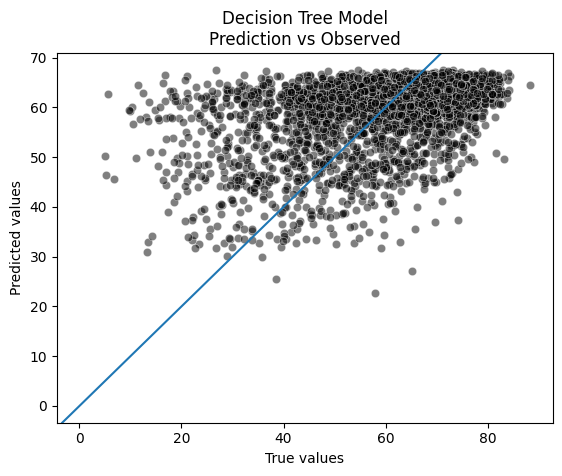

In [73]:
predicted_actual = {
    "True values": y_val, "Predicted values": models[4].predict(X_test)}
predicted_actual = pd.DataFrame(predicted_actual)

sns.scatterplot(data=predicted_actual,
                x="True values", y="Predicted values",
                color="black", alpha=0.5)
plt.axline((0, 0), slope=1, label="Perfect fit")
a_ = plt.title("Decision Tree Model\nPrediction vs Observed")

In [26]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [30]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [32]:
gridPredictionVal = models[1].predict(X_test)
gridPredictionTrain = models[1].predict(X_train)

rmse, mae, r2 = eval_metrics(y_train, gridPredictionTrain)
print (f"Desempenho no conjunto de Treino\nrmse:{rmse}    mae:{mae}    r2:{r2}")

rmse, mae, r2 = eval_metrics(y_val, gridPredictionVal)
print (f"Desempenho no conjunto de Testes (Validação)\nrmse:{rmse}    mae:{mae}    r2:{r2}")


Desempenho no conjunto de Treino
rmse:10.72715776580766    mae:8.31559005790597    r2:0.5237186409917423
Desempenho no conjunto de Testes (Validação)
rmse:12.686597952855381    mae:9.81325597441602    r2:0.3002066299011009


In [82]:
test_random_state = int(run.data.tags["test_random_state"])
test_size = float(run.data.tags["test_size"])

### Recuperação do Parâmetros do Modelo de Busca

In [85]:
#paramsRandom = eval(runRandom.data.params["param_distributions"])
paramsGrid = eval(runGrid.data.params["param_grid"])

In [90]:
uriGrid = runGrid.info.artifact_uri
uriRandom = runRandom.info.artifact_uri

### Recuperação do Modelo

In [91]:
modelGrid = mlflow.sklearn.load_model(uriGrid+"/model")
#modelRandom = mlflow.sklearn.load_model(uriRandom+"/model")

In [92]:
modelGrid

DecisionTreeRegressor(max_depth=11, max_features=5, min_samples_leaf=35,
                      min_samples_split=185, random_state=10)

In [73]:
modelRandom

DecisionTreeRegressor(max_depth=11, max_features=6, min_samples_leaf=35,
                      min_samples_split=125, random_state=10)

### Recuperação dos Resultados da Busca

In [106]:
resultsGrid = recoverResultsCSV(uriGrid+"/cv_results")
#resultsRandom = recoverResultsCSV(uriRandom+"/cv_results")

## Análise dos Experimentos <a class="anchor" id="analysis"></a>

Nessa parte faremos a análise de um dos experimentos executados. 

### Plot de Coordenadas Paralelas

No plot de cooredenadas paralelas, é possível vizualiar o desempenho do modelo com as diferentes combinações de parâmetros testadas. Cada linha corresponde a uma combinação, e sua cor indica a perforace do modelo, aferida com validação cruzada.

In [74]:
def shorten_param(param_name):
    if "param_" in param_name:
        return param_name.rsplit("param_", 1)[1]
    return param_name

def parallel_plot(cv_results,params_names, metric):
    cv_results = cv_results.copy().rename(shorten_param, axis=1)
    
    column_results = [
        f"{name}" for name in params_names]
    column_results += [metric]
    cv_results = cv_results[column_results]
    
    fig = px.parallel_coordinates(
        cv_results[column_results],
        color="mean_test_r2",
        color_continuous_scale=px.colors.sequential.Viridis,
    )
    fig.show()

In [84]:
results.columns.values

array(['mean_fit_time', 'std_fit_time', 'mean_score_time',
       'std_score_time', 'param_random_state', 'param_n_estimators',
       'param_min_samples_split', 'param_min_samples_leaf',
       'param_max_leaf_nodes', 'param_max_depth', 'params',
       'split0_test_r2', 'split1_test_r2', 'split2_test_r2',
       'split3_test_r2', 'split4_test_r2', 'mean_test_r2', 'std_test_r2',
       'rank_test_r2', 'split0_test_neg_mean_absolute_error',
       'split1_test_neg_mean_absolute_error',
       'split2_test_neg_mean_absolute_error',
       'split3_test_neg_mean_absolute_error',
       'split4_test_neg_mean_absolute_error',
       'mean_test_neg_mean_absolute_error',
       'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error',
       'split0_test_neg_root_mean_squared_error',
       'split1_test_neg_root_mean_squared_error',
       'split2_test_neg_root_mean_squared_error',
       'split3_test_neg_root_mean_squared_error',
       'split4_test_neg_root_mean_square

In [85]:
plot_params = ["max_depth",  "min_samples_split","min_samples_leaf","n_estimators","max_leaf_nodes"]

In [104]:
resultsGrid = resultsGrid.groupby("param_max_features").mean()

In [86]:
parallel_plot(results,plot_params,"mean_test_r2")


O plot acima é iterativo, é possível clicar sobre as colunas para delimitar intravalos de cada parâmetros para a visualização. Limitando a coluna "mean_test_r2", vemos que o modelo atinge melhor desempenho quando o parâmetro _mean_samples_leaf_ está em 35, e o _min_samples_split_ está por volta de 125, com o _max_depth_ em torno de 11.
Isso confirma os resultados acima dos melhores modelos encontrados.

Também é observar o comportamento dos parâmetros indidualmente. Nota-se que a baixas alturas máximas da árvore resultam em um desempenho baixo, assim como, em menor medida, os valores altos dos outros dois parâmetros. Isso deve ocorrer pois, ao limitar uma quantidade mínima de amostra por folhas, também se limita indiretamente a altura da árvore. Quando esse valor é suficientemente alto o desempenho do modelo será próximo ao de uma árvore com altura baixa.

In [87]:
parallel_plot(results,plot_params,"mean_test_r2")

In [ ]:
objects = []
with (open("../extracao/keras.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pkl.load(openfile))
        except EOFError:
            break


In [ ]:
pca = models[-1]

In [ ]:
XYGG = pd.DataFrame([o[1] for o in objects])
yYGG = pd.DataFrame([o[2] for o in objects])

In [ ]:
X_trainYGG, X_testYGG, y_trainYGG, y_testYGG = train_test_split(
    XYGG, yYGG, test_size=0.3, random_state=r_state
)


In [ ]:
y_pred_test = model.predict(pca.transform(X_test))
rmse, mae, r2 = eval_metrics(y_test, y_pred_test)
print (f"Desempenho no conjunto de Testes (Validação)\nrmse:{rmse}    mae:{mae}    r2:{r2}")

y_pred_train = model.predict(pca.transform(X_trainYGG))
rmse, mae, r2 = eval_metrics(y_train, y_pred_train)
print (f"Desempenho no conjunto de Treino\nrmse:{rmse}    mae:{mae}    r2:{r2}")


In [ ]:
y_pred_test = y_pred_test.flatten()
y_test = y_test.values.flatten()

predicted_actual = {
        "True values": y_test.flatten(), "Predicted values": model.predict(pca.transform(X_test)).flatten()}
predicted_actual = pd.DataFrame(predicted_actual)



sns.scatterplot(data=predicted_actual,
                x="True values", y="Predicted values",
                color="black", alpha=0.5)
plt.axline((0, 0), slope=1, label="Perfect fit")
plt.axis('square')
_ = plt.title("Linear Regression Model\nPrediction vs Observed")

### Plots de Desempenho por Parâmetros <a class ="anchor" id="plotScore"></a>

Nessa seção estão os gráficos do desempenho do modelo por cada parâmetro, com o total de 4 plots.

In [90]:
def plot_param_r2(df,param,ax):
    min_samples_group = df.groupby([param], as_index=False)['mean_test_r2'].mean()

    #plt.figure()
    ax.plot(min_samples_group[param],min_samples_group["mean_test_r2"])
    ax.set(xlabel=param, ylabel="r2", title=param)


    #plt.show()


In [68]:
def plot_predicted(model, ax):
    predicted_actual = {
        "True values": y_val, "Predicted values": model.predict(X_test)}
    predicted_actual = pd.DataFrame(predicted_actual)

    sns.scatterplot(data=predicted_actual,
                    x="True values", y="Predicted values",
                    color="black", alpha=0.5, ax=ax)
    ax.axline((0, 0), slope=1, label="Perfect fit")
    #ax.title("Decision Tree Model\nPrediction vs Observed")

[[<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]]


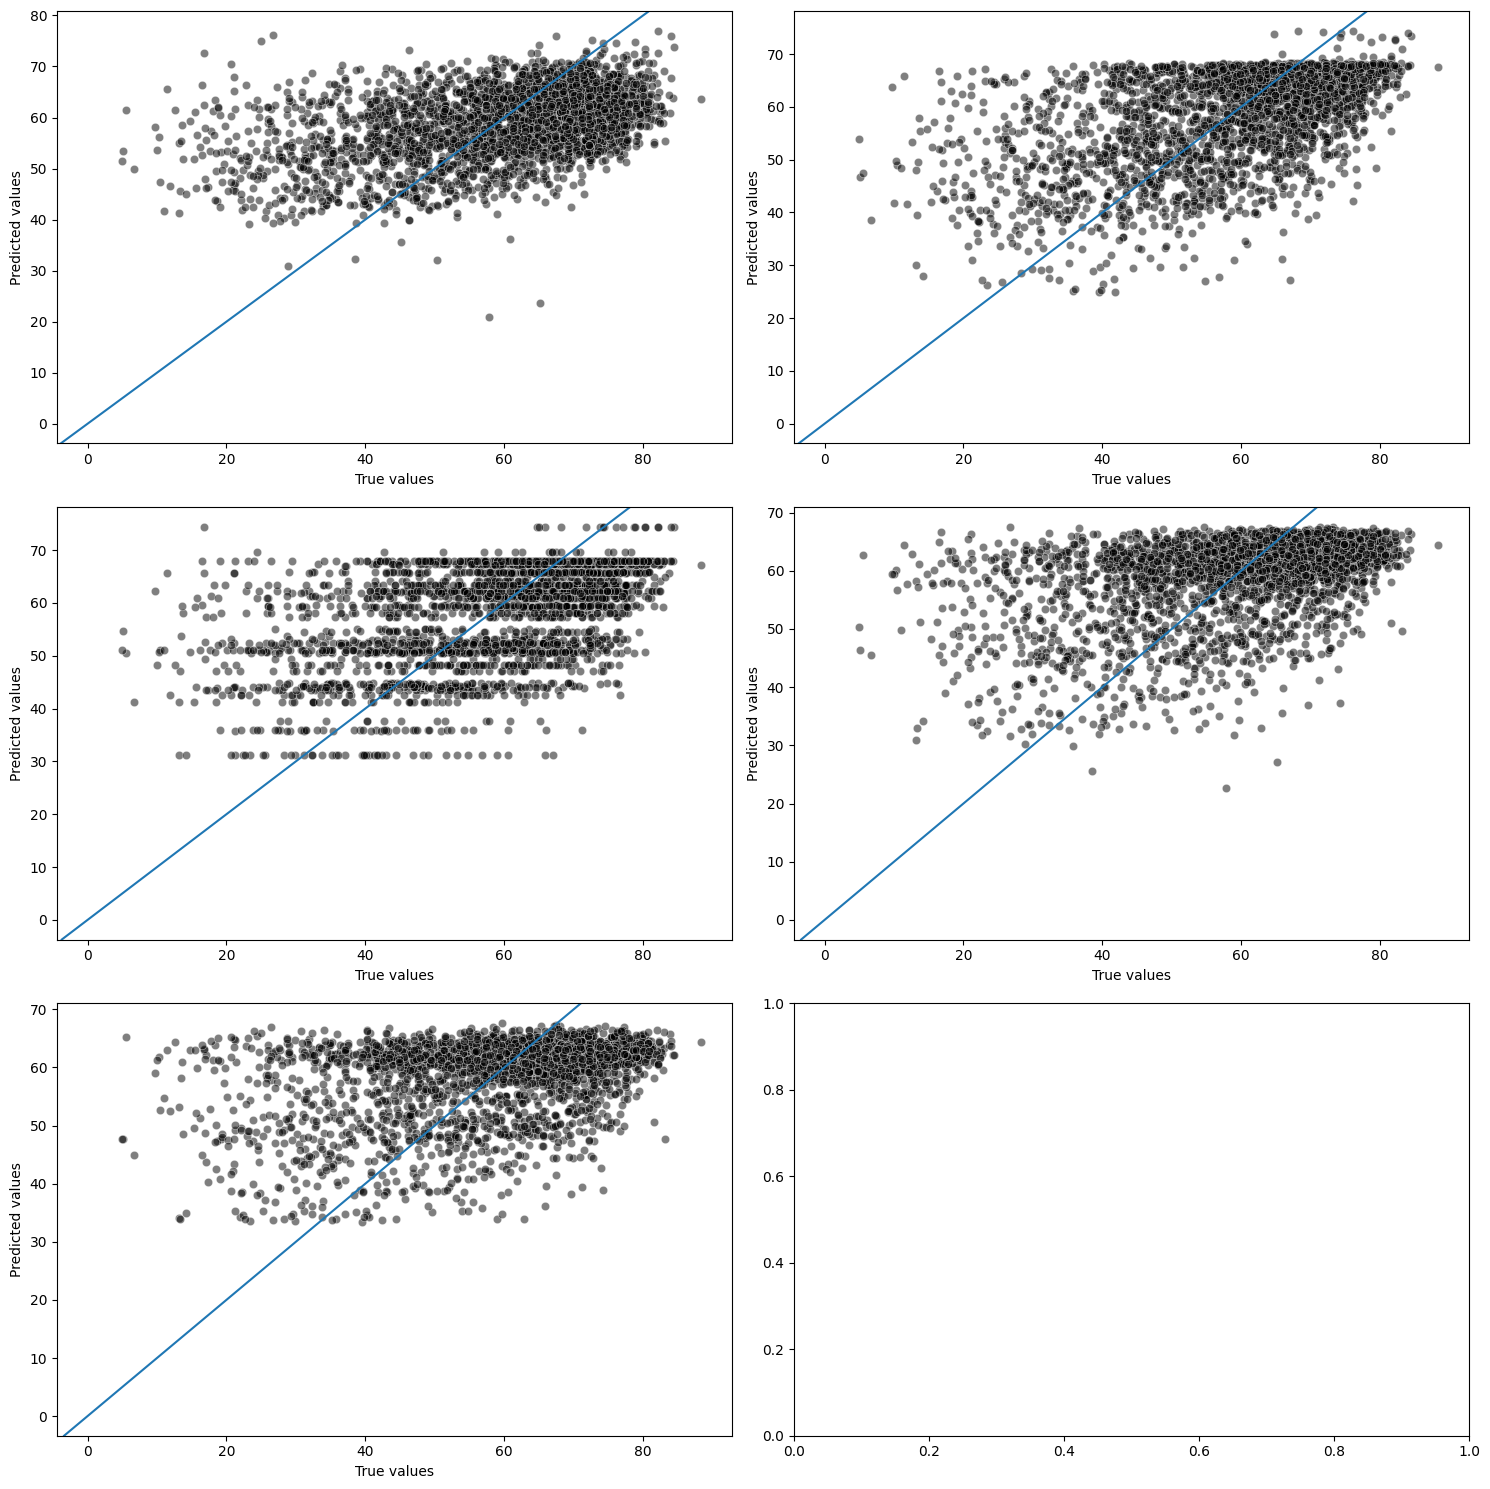

In [83]:
plot, axs = plt.subplots(3,2,figsize=(15, 15))
print (axs)
i = 0
j = 0

for model in models:
    plot_predicted(model, axs[i][j])
    i+=1
    if i == 3:
        i = 0
        j += 1
#plt.subplots_adjust(bottom=0.1, right=1.8, top=2.5)
plot.tight_layout()
#axs[0].plot(x,y)
#plot_param_r2(df, "param_max_depth",axs[1])


[[<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]]
dict_keys(['max_depth', 'min_samples_split', 'min_samples_leaf', 'n_estimators', 'max_leaf_nodes'])


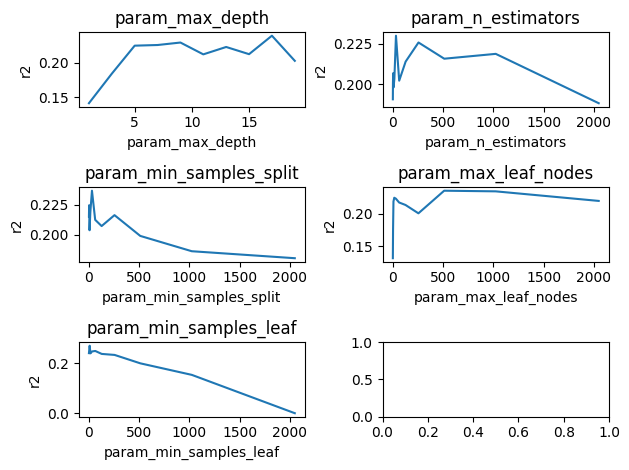

In [94]:
plot, axs = plt.subplots(3,2)
print (axs)
i = 0
j = 0
print (model_params.keys())
for name in model_params.keys():
    plot_param_r2(results, "param_" + name, axs[i][j])
    i+=1
    if i == 3:
        i = 0
        j = 1
#plt.subplots_adjust(bottom=0.1, right=1.8, top=2.5)
plot.tight_layout()
#axs[0].plot(x,y)
#plot_param_r2(df, "param_max_depth",axs[1])

Analisando os plots observa-se que o a altura da arvore é o príncipal fator para o desempenho do modelo, com alturas de 1 e 3 com os desempenhos mais negativos. Também é possível observar que o mínimo de folhas maior que 450 resulta em desempenhos piores do que os de uma árvore de altura máxima 5. Isso faz sentido pois com esse mínimo de amostras por folha, para o tamanho do set de treino (aproximadamente 6 mil), a altura resultante é no máximo 6 (uma árvore completa de tamanho 5 teria 4000 amostras).

### Plot das Previsões vs Valores Verdadeiros

In [166]:
def read_data(url):
    return pd.read_csv(os.path.abspath(url))

In [169]:
df = read_data("../extracao/datanov2.csv")

In [176]:
def getXy(df):
    r_state = 15
    df = shuffle(df, random_state=r_state)
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    return X, y
r_state = 12
X, y = getXy(df)
X_train, X_test, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=10
)


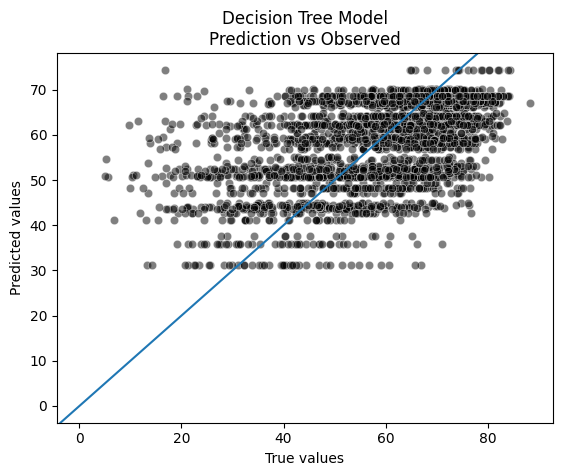

In [177]:
predicted_actual = {
    "True values": y_val, "Predicted values": model.predict(X_test)}
predicted_actual = pd.DataFrame(predicted_actual)

sns.scatterplot(data=predicted_actual,
                x="True values", y="Predicted values",
                color="black", alpha=0.5)
plt.axline((0, 0), slope=1, label="Perfect fit")
a_ = plt.title("Decision Tree Model\nPrediction vs Observed")

## Importância das Características <a class="anchor" id="featureimportance"></a>

A importância das características é calculadas com o índice gini.

In [164]:
model.feature_importances_

array([0.02786052, 0.0282795 , 0.56332204, 0.15069145, 0.04374013,
       0.18610636])